In [1]:
%cd ..

/mnt/c/python_codes/LearnKalmanGain


In [2]:
import sys
import os

from utils import plot_results_3d, plot_results_2d
from utils import partial_obs_operator, get_mean_std
from torch.utils.data import Dataset, DataLoader
from config.dataset_info import DATASET_INFO

from networks import ComplexAttentionModel, AttentionModel
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from localization import plot_GC, pairwise_distances

In [11]:
TEST_DATA = {
    'lorenz63': 'data/lorenz63/test_0_96000_v_0.150step.npy',
    'lorenz96': 'data/lorenz96/test_0_96000_v_0.150step.npy',
    'ks': 'data/ks/test_0_128000_v_1.000step.npy'
}

d = np.load(TEST_DATA['lorenz63'])
print(d[1000:].shape)

(96000, 1, 3)


In [7]:
print(d[1001:].shape)

(128000, 1, 128)


/tmp/ipykernel_1657137/664978781.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  records = torch.load(data_path)


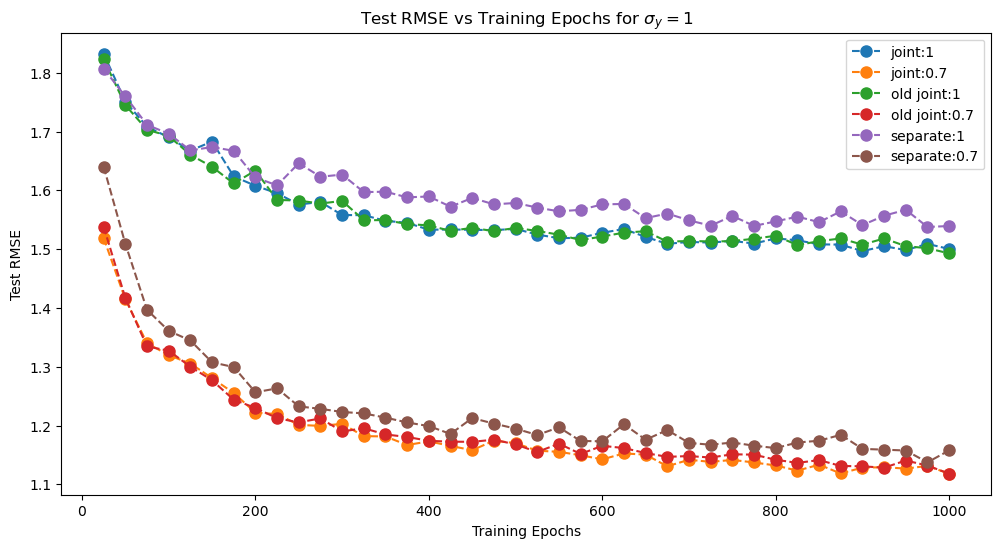

In [3]:
folder_name_list = [
    "2024-12-01_16-40lorenz96_1.0_10_60_8192_EnST_joint",
    "2024-11-28_00-50lorenz96_0.7_10_60_8192_EnST_joint",
    "2024-11-26_20-44lorenz96_1.0_10_60_8192_EnST_joint",
    "2024-11-27_00-50lorenz96_0.7_10_60_8192_EnST_joint",
    "2024-11-05_17-59lorenz96_1.0_10_60_8192_EnST_normalized_l2",
    "2024-11-06_13-43lorenz96_0.7_10_60_8192_EnST_normalized_l2"]
# folder_name_list = ["2024-11-06_11-12lorenz96_0.7_10_60_8192_EnST_l2",
#                     "2024-11-06_13-43lorenz96_0.7_10_60_8192_EnST_normalized_l2"]
# method_name_list = ['joint:1', 'joint:0.7', "v2:1", "v2:0.7", "v1:1", "v1:0.7"]
method_name_list = ['joint:1', 'joint:0.7', 'old joint:1', 'old joint:0.7', 'separate:1', 'separate:0.7']

test_loss_list = []
test_epoch_list = []
for folder_name in folder_name_list:
    data_path = os.path.join("save", folder_name, "training_records.pt")
    records = torch.load(data_path)
    test_loss_list.append(records['test_loss'])
    test_epoch_list.append(records['test_epochs'])
    
def to_cpu(L):
    return [l.cpu() if isinstance(l, torch.Tensor) else l for l in L]

plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
for i in range(len(folder_name_list)):
    plt.plot(test_epoch_list[i], to_cpu(test_loss_list[i][1:]), linestyle='--', marker='o', markersize=8, label=method_name_list[i]) 
plt.legend(loc='upper right')
plt.title(r'Test RMSE vs Training Epochs for $\sigma_y=1$')
plt.xlabel("Training Epochs")
plt.ylabel("Test RMSE")

# plt.savefig(os.path.join('save/figures', f"Test_RMSE_vs_Training_Epochs_10.png"), bbox_inches="tight", dpi=200)
plt.show()

/tmp/ipykernel_1657137/284091861.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  records = torch.load(data_path)


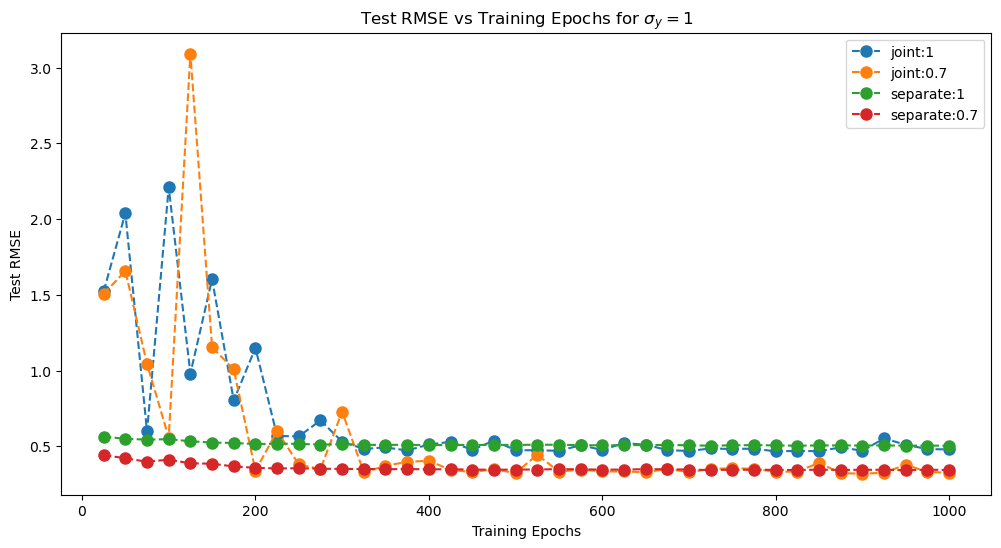

In [8]:
folder_name_list = [
    "2024-11-28_04-56ks_1.0_10_60_8192_EnST_joint",
    "2024-12-01_20-43ks_0.7_10_60_8192_EnST_joint",
    "2024-11-13_13-41ks_1.0_10_60_8192_EnST_normalized_l2",
    "2024-11-13_23-15ks_0.7_10_60_8192_EnST_normalized_l2"]
# method_name_list = ['joint:1', 'joint:0.7', "v2:1", "v2:0.7", "v1:1", "v1:0.7"]
method_name_list = ['joint:1', 'joint:0.7', 'separate:1', 'separate:0.7']

test_loss_list = []
test_epoch_list = []
for folder_name in folder_name_list:
    data_path = os.path.join("save", folder_name, "training_records.pt")
    records = torch.load(data_path)
    test_loss_list.append(records['test_loss'])
    test_epoch_list.append(records['test_epochs'])
    
def to_cpu(L):
    return [l.cpu() if isinstance(l, torch.Tensor) else l for l in L]

plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
for i in range(len(folder_name_list)):
    plt.plot(test_epoch_list[i], to_cpu(test_loss_list[i][1:]), linestyle='--', marker='o', markersize=8, label=method_name_list[i]) 
plt.legend(loc='upper right')
plt.title(r'Test RMSE vs Training Epochs for $\sigma_y=1$')
plt.xlabel("Training Epochs")
plt.ylabel("Test RMSE")

# plt.savefig(os.path.join('save/figures', f"Test_RMSE_vs_Training_Epochs_10.png"), bbox_inches="tight", dpi=200)
plt.show()

/tmp/ipykernel_1657137/230700933.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  records = torch.load(data_path)


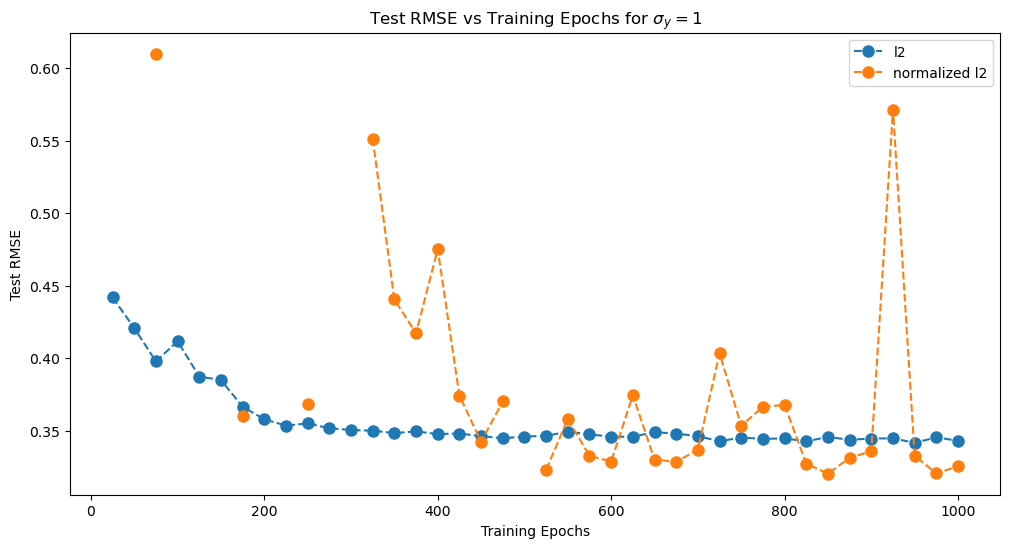

In [5]:
folder_name_list = ["2024-11-13_23-15ks_0.7_10_60_8192_EnST_normalized_l2",
                    "2024-11-15_11-19ks_0.7_10_60_8192_EnST_normalized_l2_v2"]
method_name_list = ['l2', 'normalized l2']

test_loss_list = []
test_epoch_list = []
for folder_name in folder_name_list:
    data_path = os.path.join("save", folder_name, "training_records.pt")
    records = torch.load(data_path)
    test_loss_list.append(records['test_loss'])
    test_epoch_list.append(records['test_epochs'])

plt.figure(figsize=(12, 6))  # Adjusted figure size to elongate x-axis
for i in range(len(folder_name_list)):
    plt.plot(test_epoch_list[i], test_loss_list[i][1:], linestyle='--', marker='o', markersize=8, label=method_name_list[i]) 
plt.legend(loc='upper right')
plt.title(r'Test RMSE vs Training Epochs for $\sigma_y=1$')
plt.xlabel("Training Epochs")
plt.ylabel("Test RMSE")

# plt.savefig(os.path.join('save/figures', f"Test_RMSE_vs_Training_Epochs_10.png"), bbox_inches="tight", dpi=200)
plt.show()